In [190]:
import torch
import torch.nn.functional as F
from torch import Tensor
import math
import random
from mynn import *
import numpy as NP
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
from collections import Counter

dtype = torch.float
dvc = torch.device('cpu')
rndSeed = 42
trRatio = 0.8
devRatio = 0.9
contextSize = 3
embeddingDims = 10
hiddenLayerSize = 200
trainingBatchSize = 32
rndSeed2 = 2147483647
g = torch.Generator(device=dvc).manual_seed(rndSeed2)
gSampling = torch.Generator(device=dvc).manual_seed(rndSeed2 + 10)

words = readFileSplitByLine('names.txt')
random.seed(rndSeed)
random.shuffle(words)
print('first few words:\t', words[:5])

lenWords = len(words);
print('lenWords:\t', lenWords)

allPossibleChars = sorted(list(set(''.join(words))))
print('allPossibleChars:\t', allPossibleChars)

stoi = sToI(allPossibleChars)
print('stoi:\t', stoi)

itos = iToS(stoi)
print('itos:\t', itos)

vocabularyLength = len(itos)
print('vocabularyLength:\t', vocabularyLength)

lenTrain = int(trRatio * lenWords)
trWords = words[:lenTrain]
trX, trY = buildDataSet(trWords, contextSize, stoi, itos, dvc)
print('data set training:\t', lenTrain, trX.shape, trY.shape, trWords[:3])

endDev = int(devRatio * lenWords)
devWords = words[lenTrain:endDev];
devX, devY = buildDataSet(devWords, contextSize, stoi, itos, dvc)
print('data set dev:\t', endDev - lenTrain, devX.shape, devY.shape, devWords[:3])

lenTest = lenWords - endDev
tstWords = words[endDev:]
tstX, tstY = buildDataSet(tstWords, contextSize, stoi, itos, dvc)
print('data set test:\t', lenTest, tstX.shape, tstY.shape, tstWords[:3])

np = makeNetwork(g, vocabularyLength, embeddingDims, contextSize, hiddenLayerSize, dvc)
print('parametersCount:\t', sum(p.nelement() for p in np.all))

print(f'random probability:\t {-torch.tensor(1 / vocabularyLength).log().item():.4f}')

@torch.no_grad()
def trLoss(): return getLoss(np, np.C[trX], trY)

@torch.no_grad()
def devLoss(): return getLoss(np, np.C[devX], devY)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[tstX], tstY)

class Losses:
    tr: Loss
    dev: Loss
    tst: Loss

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.dev = devLoss()
    l.tst = tstLoss()
    return l

def printLosses():
    losses = getLosses()
    l1 = f'{losses.tr.loss.item():>10.4f}'
    l2 = f'{losses.dev.loss.item():>10.4f}'
    l3 = f'{losses.tst.loss.item():>10.4f}'
    print(f'{l1} {l2} {l3}')

trXLength = trX.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
print ('trainingSteps: \t', trainingSteps)

lr = 0.1;
lre = torch.linspace(-3, 0, trainingSteps)
lrs = 10 ** lre
lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
up = UpdateNetResult()

first few words:	 ['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
lenWords:	 32033
allPossibleChars:	 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:	 {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos:	 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocabularyLength:	 27
data set training:	 25626 torch.Size([182625, 3]) torch.Size([182625]) ['yuheng', 'diondre', 'xavien']
data set dev:	 3203 torch.Size([22655, 3]) torch.Size([22655]) ['amay', 'aytana', 'jenevi']
data set test:	 3204 torch.Size([22866, 3]) torch.Size([22866]) 

learning rates 0.135 0.0001
actualIterations:	 200000
  0,      0 losses:     0.0000       3.3058     3.3057     3.3058
  1,   5708 losses:     2.1582       2.2912     2.3040     2.3007
  2,  11416 losses:     2.3041       2.2483     2.2631     2.2602
  3,  17124 losses:     2.0355       2.2248     2.2447     2.2426
  4,  22832 losses:     2.1074       2.2010     2.2257     2.2300
  5,  28540 losses:     2.2690       2.1966     2.2308     2.2240
  6,  34248 losses:     1.9624       2.1738     2.2056     2.2078
  7,  39956 losses:     2.2954       2.1543     2.1957     2.1869
  8,  45664 losses:     1.9261       2.1527     2.1869     2.1924
  9,  51372 losses:     2.1990       2.1585     2.1967     2.1997
 10,  57080 losses:     2.2887       2.1471     2.1880     2.1880
 11,  62788 losses:     2.5182       2.1366     2.1828     2.1821
 12,  68496 losses:     2.0074       2.1310     2.1841     2.1797
 13,  74204 losses:     1.9231       2.1205     2.1784     2.1659
 14,  79912 losses:   

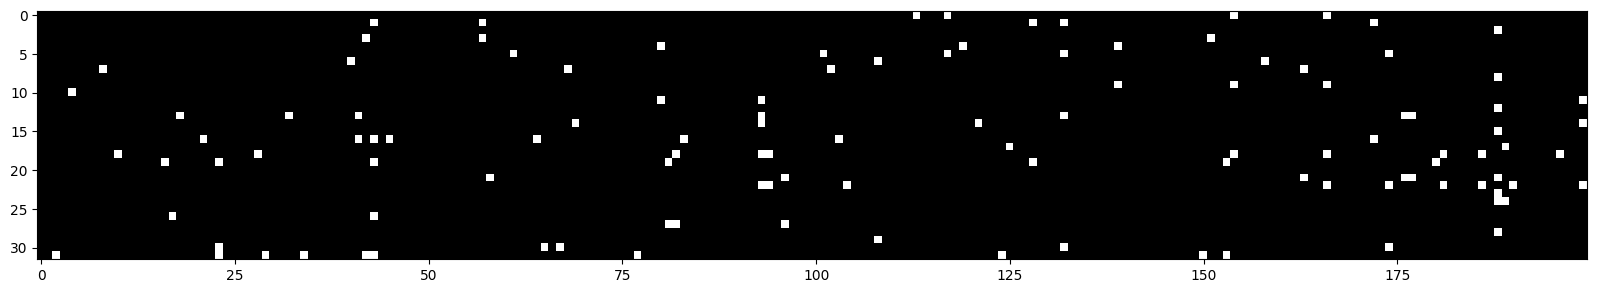

In [192]:
i = 0
maxIteration = 200_000
maxRepeat = 36
maxLr = 0.14
minLr = 0.0001
print('learning rates', maxLr, minLr)

actualIterations = min(maxIteration, maxRepeat * math.ceil(trXLength / trainingBatchSize))
print('actualIterations:\t', actualIterations)

for repeat in range(maxRepeat):
    
    print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ', end='')
    printLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            print('break')
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        #miniBatchIxs = torch.arange(start, end)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, trX, trY, miniBatchIxs)
        
        backwardPass(np.all, fr.loss)

        if i == 1:
            plt.figure(figsize=(20,10))
            plt.imshow(fr.h.abs() > 0.99, cmap='gray', interpolation='nearest')
        
        up = updateNet(np.all, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)

        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())

        #lr = lrs[i].item()
        #lrAtIx.append(lrs[i].item())

        #if repeat == 0 and i % (trainingBatchSize * 10) == 0:
        #    print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ')

        #if i % 10_000 == 0:
        #    print(f'{repeat:>3}, {i:>6} losses: {fr.loss.item():>10.4f}   ')
        
        i += 1

printLosses()

#bestLr = lrs[findLowestIndex(lossAtIx)].item();
#print('best learning rate:\t', bestLr)
print('emb.shape:\t', fr.emb.shape)
print('h.shape:\t', fr.h.shape)
print('logits.shape:\t', fr.logits.shape)

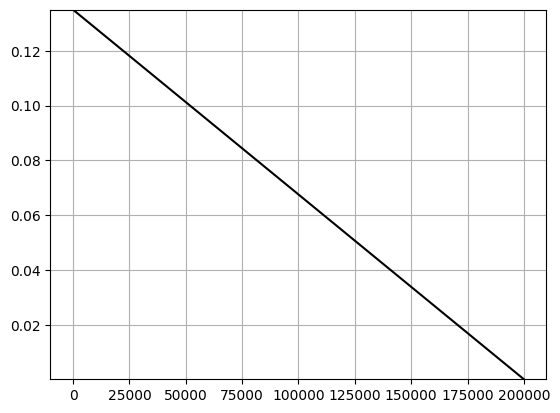

0.135 0.00010067450000000866


In [193]:
plt.plot(range(len(lrAtIx)), lrAtIx, 'black')
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
print(max(lrAtIx), min(lrAtIx))

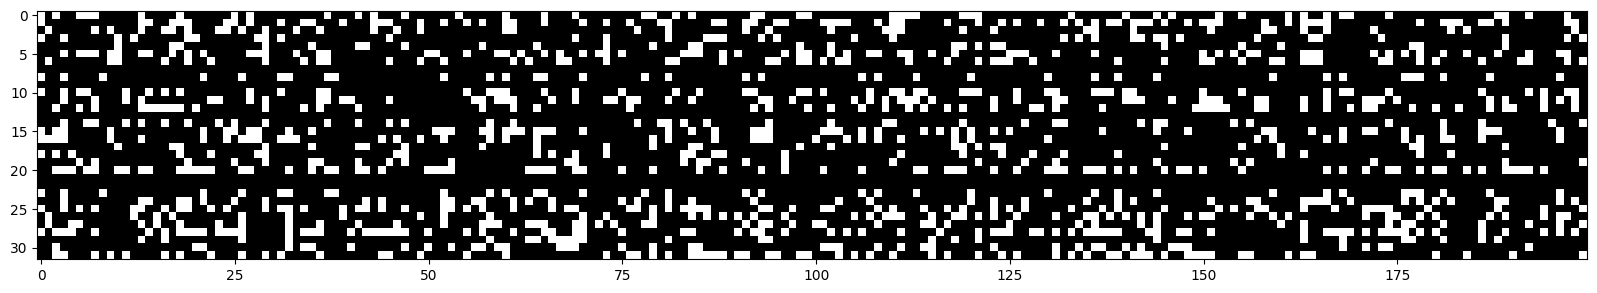

In [194]:
plt.figure(figsize=(20,10))
plt.imshow(fr.h.abs() > 0.99, cmap='gray', interpolation='nearest')

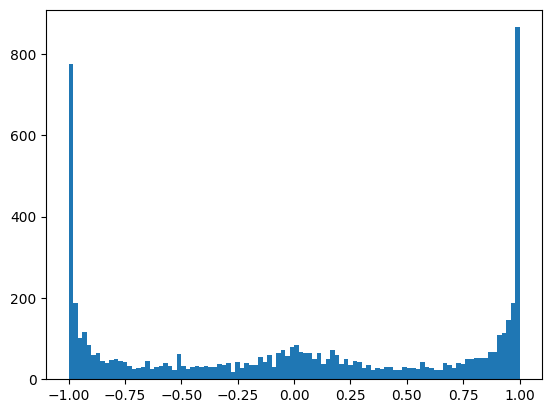

In [195]:
plt.hist(fr.h.view(-1).tolist(), 100);

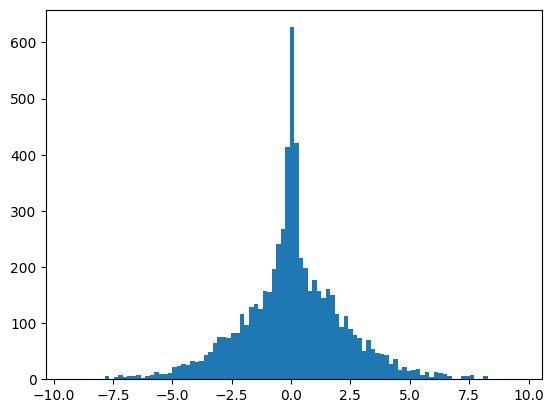

In [196]:
plt.hist(fr.hPreActivations.view(-1).tolist(), 100);

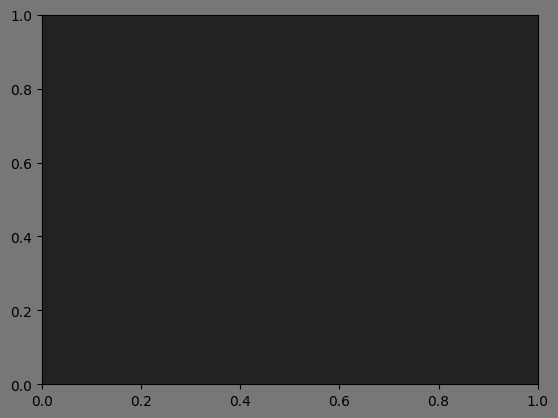

In [197]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
#ax.plot(lrAtIx, lossAtIx)
plt.show()

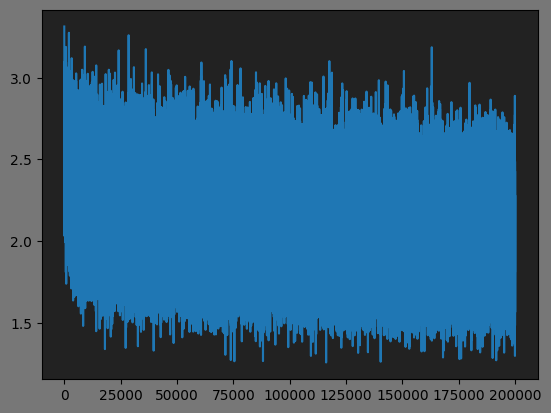

In [198]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, lossAtIx)
plt.show()

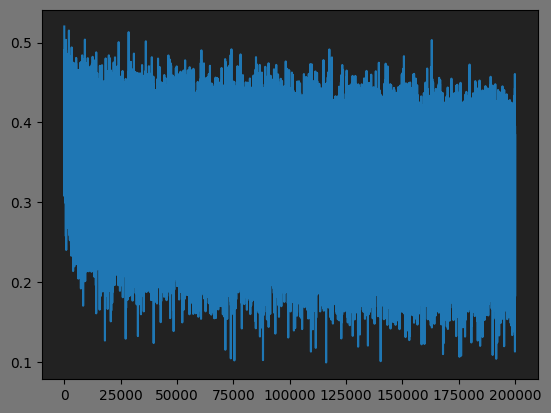

In [199]:
fig, ax = plt.subplots()
fig.set_facecolor('#777777')
ax.set_facecolor('#222222')
ax.plot(stepIx, logLossAtIx)
plt.show()

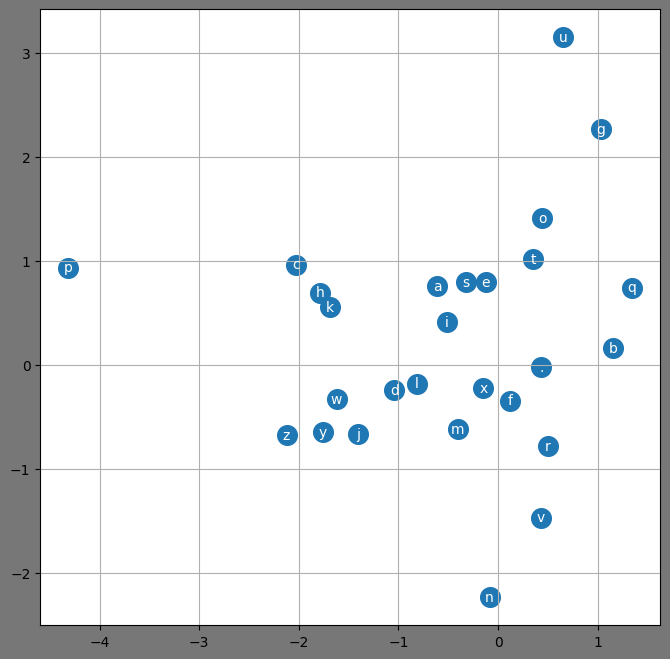

In [200]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('#777777')
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [201]:
samples = sample(np, gSampling, contextSize, itos, 20)
for s in samples:
    print(''.join(s.values) + '  ', end='')
    for p in [s.prob] + s.probs:
        print(f'{(p * 100):.0f} ', end='')
    print()

carmahzailyn.  2308328461 124 1128 574 295 1107 36 66 885 843 529 591 1611 1260 
kitzimri.  4473 250 243 91 140 527 21 132 891 404 
reity.  40420 141 412 482 65 608 2178 
skaelane.  580462 176 78 353 195 1728 483 835 99 795 
rahni.  25092 141 762 165 42 1044 1950 
farelynn.  106499993 37 1056 739 276 585 426 1747 1204 2311 
kaeli.  87453 250 1163 99 1728 403 262 
nellara.  795623 94 390 312 1164 786 152 387 1028 
chaily.  514776 124 567 1225 192 772 591 479 
kaleigh.  295050385 250 1163 316 679 469 1552 2470 2107 
ham.  3746 76 1525 158 820 
joce.  18563 209 473 75 1084 1151 
quintis.  3323426 8 2480 1377 1517 389 522 248 1314 
lilea.  39766 132 463 883 220 201 1007 
jadis.  52797 209 1429 84 548 279 824 
watero.  2732 27 649 124 359 480 68 749 
dearynix.  27950 144 815 195 418 98 284 53 79 2227 
kael.  71410 250 1163 99 1728 719 
dustine.  7795209 144 55 992 1066 823 1262 331 2163 
deci.  4820 144 815 92 613 363 


In [202]:
ps = calcProb(np, 'mel.', contextSize, stoi)
op = calcOneProb(ps)
for p in [op] + ps:
    print(f'{(p * 100):.0f} ', end='')

4751 205 318 784 371 

In [203]:
np.C.shape, trX.shape, np.C[trX].shape, np.C[:5], trX[:5], np.C[trX][:5]

(torch.Size([27, 10]),
 torch.Size([182625, 3]),
 torch.Size([182625, 3, 10]),
 tensor([[ 0.4337, -0.0197,  0.1524,  0.0995,  0.3696, -0.0916, -0.3646,  0.0301,
           0.0511,  0.2770],
         [-0.6123,  0.7556, -0.1926, -0.2098,  1.1527,  1.7822,  0.4837, -0.7745,
           0.5164, -0.8202],
         [ 1.1553,  0.1627, -1.7158,  0.6466, -0.6312,  2.7638,  2.7576, -0.3652,
          -1.1014,  1.3239],
         [-2.0314,  0.9628,  0.2928,  1.1362, -0.9180, -0.7791, -1.3598,  1.7942,
          -1.2241,  1.1635],
         [-1.0424, -0.2400,  0.1526,  1.4890, -1.4057,  1.8573,  0.3429,  1.5172,
           0.2352, -0.9849]], grad_fn=<SliceBackward0>),
 tensor([[ 0,  0,  0],
         [ 0,  0, 25],
         [ 0, 25, 21],
         [25, 21,  8],
         [21,  8,  5]]),
 tensor([[[ 0.4337, -0.0197,  0.1524,  0.0995,  0.3696, -0.0916, -0.3646,
            0.0301,  0.0511,  0.2770],
          [ 0.4337, -0.0197,  0.1524,  0.0995,  0.3696, -0.0916, -0.3646,
            0.0301,  0.0511,  0.27

In [204]:
import torch
import math# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [205]:
# Let's suppose these are your lists
C = [
[ 0.8774, -0.6801],
         [ 0.1651, -0.5025],
         [ 0.2769, -0.3570],
         [-0.8820,  0.3902],
         [-0.4824,  0.8744],
         [-0.3190,  0.7807],
         [-0.0100, -0.3401],
         [ 0.9975,  2.8280],
         [ 0.9623, -1.3172],
         [ 0.2180, -0.3820],
         [ 0.6139, -0.4287],
         [-0.7386,  0.5880],
         [-0.3088,  0.9816],
         [ 0.3907, -0.4174],
         [-0.7380,  0.5205],
         [-0.5288,  0.7074],
         [-0.3956,  0.9625],
         [-0.3802, -0.3504],
         [-0.2861,  0.7589],
         [ 0.5309, -0.5105],
         [-0.0922, -0.6410],
         [-0.3823,  0.9899],
         [ 0.0965, -0.5708],
         [-0.8582, -1.3429],
         [-0.4960,  0.2842],
         [-0.6105,  0.1336],
         [-0.2623,  0.2942]
]
trX = [
    [0, 0, 0],
    [0, 0, 22],
    [0, 22, 9],
    [22, 9, 15],
    [9, 15, 12],
    # ... More values
]

# We create a new list to hold the result
result = []

# We loop over each element in trX
for i in range(len(trX)):
    temp = []
    # Then we loop over each value in the element
    for j in range(len(trX[i])):
        # We use the value as an index to get the corresponding data from C
        temp.append(C[trX[i][j]])
    # We add the result to our new list
    result.append(temp)

# Let's print the first 5 elements of the result list
for i in range(5):
    print(result[i])

[[0.8774, -0.6801], [0.8774, -0.6801], [0.8774, -0.6801]]
[[0.8774, -0.6801], [0.8774, -0.6801], [0.0965, -0.5708]]
[[0.8774, -0.6801], [0.0965, -0.5708], [0.218, -0.382]]
[[0.0965, -0.5708], [0.218, -0.382], [-0.5288, 0.7074]]
[[0.218, -0.382], [-0.5288, 0.7074], [-0.3088, 0.9816]]
